<a href="https://colab.research.google.com/github/AnirudhSB/AI-Hub/blob/main/Lane_Detection/LaneDetection_VGGNet_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Modules
Import torch related packages to get the pretrained VGGNet16 model and note down the layers within the model.

In [1]:
# get VGGNET16 from pytorch
import torch
import torchvision
from torchsummary import summary

model = torchvision.models.vgg16(pretrained=True)
# Assuming your model is named 'model'
print(model)
for name, layer in model.features.named_children():
    print(f"Layer name: {name}, Layer type: {type(layer).__name__}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 138MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#Dataset
Get the Datatset from Kaggel and load via Kaggel apis

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sakshaymahna_kittiroadsegmentation_path = kagglehub.dataset_download('sakshaymahna/kittiroadsegmentation')

print('Data source import complete.')

100%|██████████| 305M/305M [00:11<00:00, 26.8MB/s]

Extracting files...


Data source import complete.


Set up the train, test and validation datasets
Use image size, number of channels, number of classes (used 1, since we only want a binary mask , 1s where the lane is predicted and 0 elsewhere)

In [3]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2
from tqdm import tqdm
import datetime
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

from IPython.display import HTML
from base64 import b64encode

# Load directories
train_data_dir = "/root/.cache/kagglehub/datasets/sakshaymahna/kittiroadsegmentation/versions/1/training/image_2/"
train_gt_dir = "/root/.cache/kagglehub/datasets/sakshaymahna/kittiroadsegmentation/versions/1/training/gt_image_2/"

test_data_dir = "/root/.cache/kagglehub/datasets/sakshaymahna/kittiroadsegmentation/versions/1/testing/"

# Number of training examples
TRAINSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.8)
print(f"Number of Training Examples: {TRAINSET_SIZE}")

VALIDSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.1)
print(f"Number of Validation Examples: {VALIDSET_SIZE}")

TESTSET_SIZE = int(len(os.listdir(train_data_dir)) - TRAINSET_SIZE - VALIDSET_SIZE)
print(f"Number of Testing Examples: {TESTSET_SIZE}")

# Initialize Constants
IMG_SIZE = 128
N_CHANNELS = 3
N_CLASSES = 1
SEED = 123

Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


Create a dataset custom class.

Note:




*   Loads images and masks from a directory.
*   Splits data into training, validation, and test sets.
*   Preprocesses images and masks (resizing, normalization, converting masks to binary).
*   Applies data augmentation (random horizontal flips) during training.
*  train_dataset, val_dataset, test_dataset using the SegmentationDataset class.
*   train_loader, val_loader, test_loader using the datasets for batching and iterating during training and evaluation








In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, data_dir, train=True, val_split=0.2, test_split=0.1, seed=42):
        self.data_dir = data_dir
        self.train = train

        # Get all image paths
        image_paths = [os.path.join(data_dir, img_name) for img_name in os.listdir(data_dir) if img_name.endswith(".png")]

        # Shuffle image paths using the seed for reproducibility
        random.seed(seed)
        random.shuffle(image_paths)

        # Calculate split indices
        total_len = len(image_paths)
        train_len = int(total_len * (1 - val_split - test_split))
        val_len = int(total_len * val_split)

        # Split paths based on train/val/test
        if self.train:
            self.image_paths = image_paths[:train_len]
        elif val_split > 0: # If val_split is 0, use remaining as test
            self.image_paths = image_paths[train_len:train_len + val_len]
        else:
            self.image_paths = image_paths[train_len + val_len:]

        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        self.road_label = np.array([255, 0, 255])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Get mask path and load mask
        mask_path = img_path.replace("image_2", "gt_image_2")
        mask_path = mask_path.replace("um_", "um_road_")
        mask_path = mask_path.replace("umm_", "umm_road_")
        mask_path = mask_path.replace("uu_", "uu_road_")
        mask = Image.open(mask_path).convert('RGB')

        # Convert mask to binary
        mask_np = np.array(mask)
        mask_binary = np.all(mask_np == self.road_label, axis=2)
        mask = Image.fromarray(mask_binary.astype(np.uint8))

        # Apply transforms
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Resize
        resize_transform = transforms.Resize((IMG_SIZE, IMG_SIZE))
        image = resize_transform(image)
        mask = resize_transform(mask)

        # Normalize image
        image = (image - image.min()) / (image.max() - image.min())
        # image = image.type(torch.float32) / 255.0
        mask = torch.where(mask > 0, torch.tensor(1.0), torch.tensor(0.0))


        # Data augmentation (only for training)
        if self.train:
            if random.random() > 0.5:
                image = transforms.functional.hflip(image)
                mask = transforms.functional.hflip(mask)

        return image, mask

train_dataset = SegmentationDataset(train_data_dir, train=True)
val_dataset = SegmentationDataset(train_data_dir, train=False, val_split=0.2)
test_dataset = SegmentationDataset(train_data_dir, train=False, val_split=0, test_split=0.1)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.Size([3, 128, 128]) torch.Size([1, 128, 128]) <class 'torch.Tensor'>


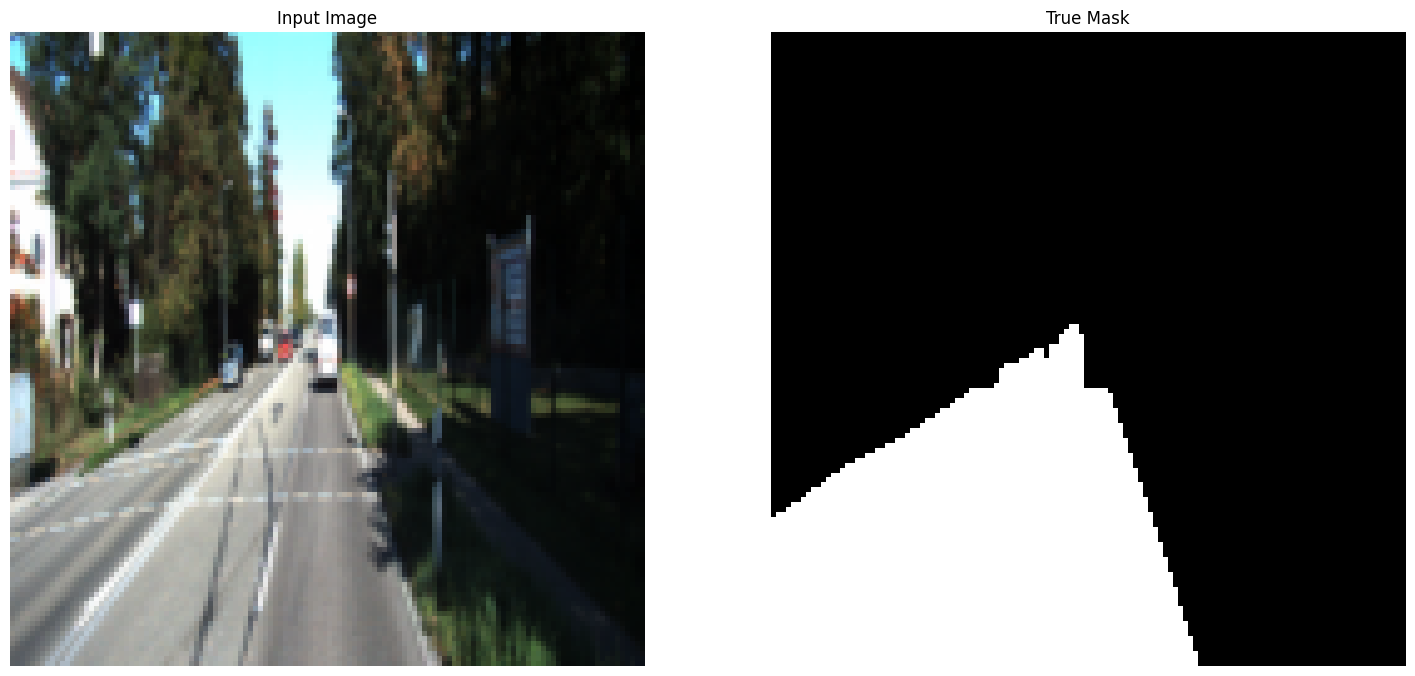

In [5]:
import matplotlib.pyplot as plt
import torch
import numpy as np


def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])

        image_np = display_list[i] #.cpu().numpy()  # Move to CPU if necessary
        # Handle different image shapes
        if image_np.shape[0] == 3:  # RGB (3, 128, 128)
            plt.imshow(image_np.permute(1,2, 0))
        elif image_np.shape[0] == 1:  # Grayscale (1, 128, 128)
            plt.imshow(image_np[0], cmap='gray')  # Squeeze the channel dimension
        else:
            raise ValueError(f"Unsupported image shape: {image_np.shape}")

        plt.axis('off')
    plt.show()

sample_image = train_dataset[1][0]
sample_mask = train_dataset[1][1]
print(sample_image.shape, sample_mask.shape, type(sample_image))
# Display the sample
display_sample([sample_image, sample_mask])

#Model Architecture
1.	Architecture: Fully Convolutional Network (FCN) based on VGG16.
2.	Purpose: Image segmentation, specifically road segmentation.
3.	Encoder:
 *  Uses pre-trained VGG16 feature extraction layers.
 *	Extracts features from VGG16 layers 16, 23, and 30.
4.	Decoder:
 *	Upsamples features with bilinear interpolation.
 *	Uses skip connections to combine encoder and decoder features.
 *	Recovers spatial information.
5.	Output:
 *	Convolutional layer with sigmoid activation for pixel-wise probabilities.
 *	Predicts binary mask (road/background).
6.	Key Components:
 *	nn.Upsample: Upsamples feature maps.
 *	nn.Conv2d: Convolutions in downsampler and output.
 *	nn.Sigmoid: Output activation for probabilities.
 *	Skip connections: Better localization.
7.	Pre-trained Weights: VGG16 encoder initialized with pre-trained weights for faster learning.
8.	Training: Adam optimizer and BCELoss for minimizing prediction errors.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


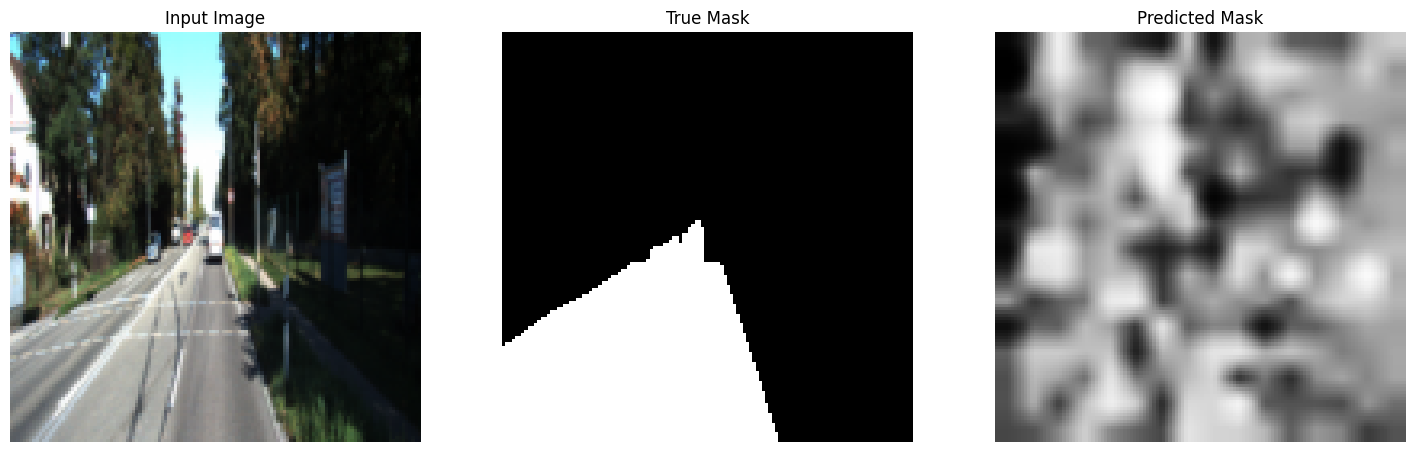

In [6]:
import torch
import torch.nn as nn
import torchvision

class VGG_FCN8(nn.Module):
    def __init__(self, n_classes):
        super(VGG_FCN8, self).__init__()
        self.n_classes = n_classes

        # Load the pre-trained VGG16 model without the classification layers
        vgg16 = torchvision.models.vgg16(pretrained=True)
        self.features = vgg16.features

        # Encoder layers
        self.c1 = None
        self.c2 = None
        self.c3 = None
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.up3 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=False)

        # conv2d layers
        self.downsampler = nn.Conv2d(512, 256, kernel_size=1)

        # Output layer
        self.output_conv = nn.Conv2d(256, n_classes, kernel_size=1)  # Adjust in_channels as needed
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        for i, layer in enumerate(self.features):
            x = layer(x)
            if i == 16:  # Adjust index to get output after block3_pool
                self.c1 = x
            elif i == 23:  # Adjust index to get output after block4_pool
                self.c2 = x
            elif i == 30:  # Adjust index to get output after block5_pool
                self.c3 = x

        # Decoder
        u1 = self.up1(self.c3)
        d1 = torch.add(u1, self.c2)
        # d1 = nn.Conv2d(d1.shape[1], 256, kernel_size=1)(d1)
        d1 = self.downsampler(d1)
        # d1 = nn.Sigmoid()(d1)

        u2 = self.up2(d1)
        d2 = torch.add(u2, self.c1)
        # d2 = nn.Conv2d(d2.shape[1], 256, kernel_size=1)(d2)
        # d2 = nn.Sigmoid()(d2)

        # Output
        u3 = self.up3(d2)
        outputs = self.output_conv(u3)
        outputs = self.sigmoid(outputs)

        return outputs

# Create the model
model = VGG_FCN8(n_classes=N_CLASSES)

# Input tensor
inputs = torch.randn(1, N_CHANNELS, IMG_SIZE, IMG_SIZE)  # Example input

# Get the output
outputs = model(inputs)
model.eval()
sample_pred = model(sample_image.unsqueeze(0)).detach()
x = sample_pred.squeeze(0).shape
display_sample([sample_image, sample_mask, sample_pred.squeeze(0)])

#Training and Validation

In [ ]:
import torch
from tqdm import tqdm  # For progress bar
!pip install torchmetrics

import torch
from torch import nn, optim
from torch.nn import functional as F
from torchmetrics import MeanMetric, JaccardIndex
# Training parameters
epochs = 200  # Number of training epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

# Move model to device
model = model.to(device)

# Define optimizer optimizer = optim.Adam(effViT_model.parameters(), lr=0.001, weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)

# Define loss function
criterion = nn.BCELoss()  # Binary Cross Entropy Loss

# Define metric
m_iou = JaccardIndex(task="binary").to(device)
iou_metric = MeanMetric().to(device)

def train_step(images, labels):
    model.train()
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Calculate and accumulate IoU
    iou = m_iou(outputs, labels)
    iou_metric.update(iou)

    return loss.item(), iou.item()

def val_step(images, labels):
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Calculate and accumulate IoU
        iou = m_iou(outputs, labels)
        iou_metric.update(iou)

    return loss.item(), iou.item()

# Training loop
for epoch in range(epochs):
    # Training phase
    train_loss = 0.0
    train_iou = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
        images = images.to(device)
        labels = labels.to(device)
        loss, iou = train_step(images, labels)
        train_loss += loss
        train_iou += iou

    # Calculate average training loss and IoU
    avg_train_loss = train_loss / len(train_loader)
    avg_train_iou = train_iou / len(train_loader)

    # Validation phase
    val_loss = 0.0
    val_iou = 0.0
    for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation"):
        images = images.to(device)
        labels = labels.to(device)
        loss, iou = val_step(images, labels)
        val_loss += loss
        val_iou += iou

    # Calculate average validation loss and IoU
    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)

    # Print epoch results
    print(f"Epoch {epoch + 1}/{epochs}:")
    print(f"  Training Loss: {avg_train_loss:.4f}, Training IoU: {avg_train_iou:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}, Validation IoU: {avg_val_iou:.4f}")

# Save the trained model
torch.save(model.state_dict(), "trained_model.pth")  # Choose your desired file name

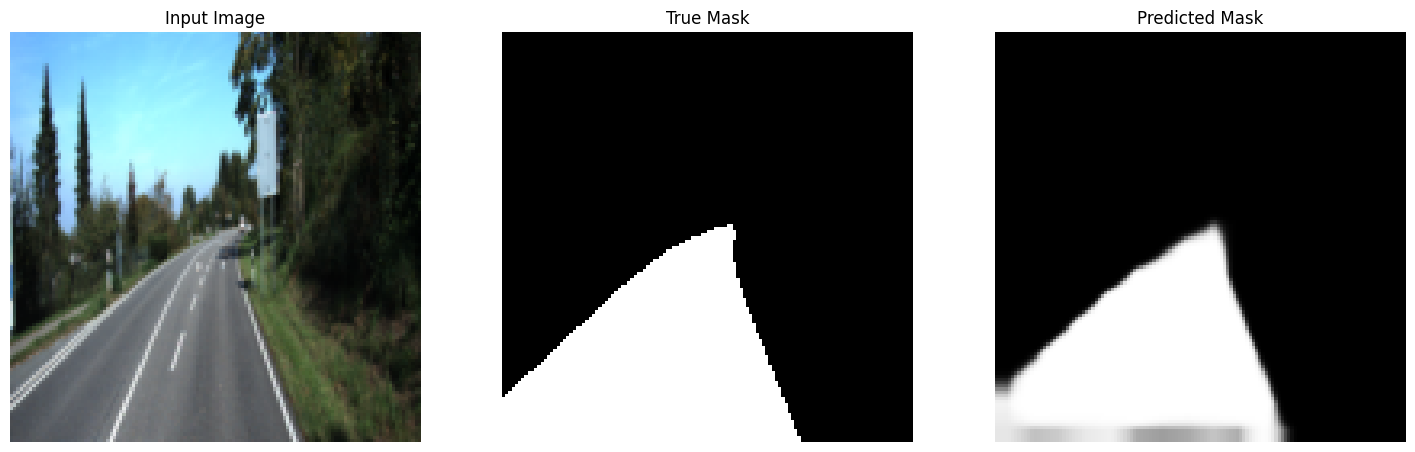

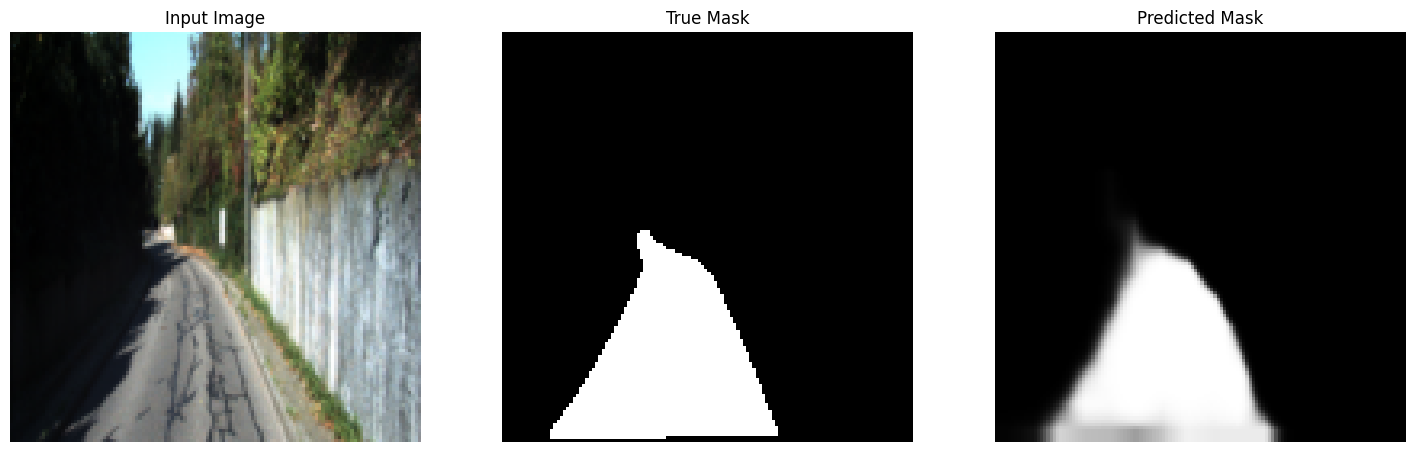

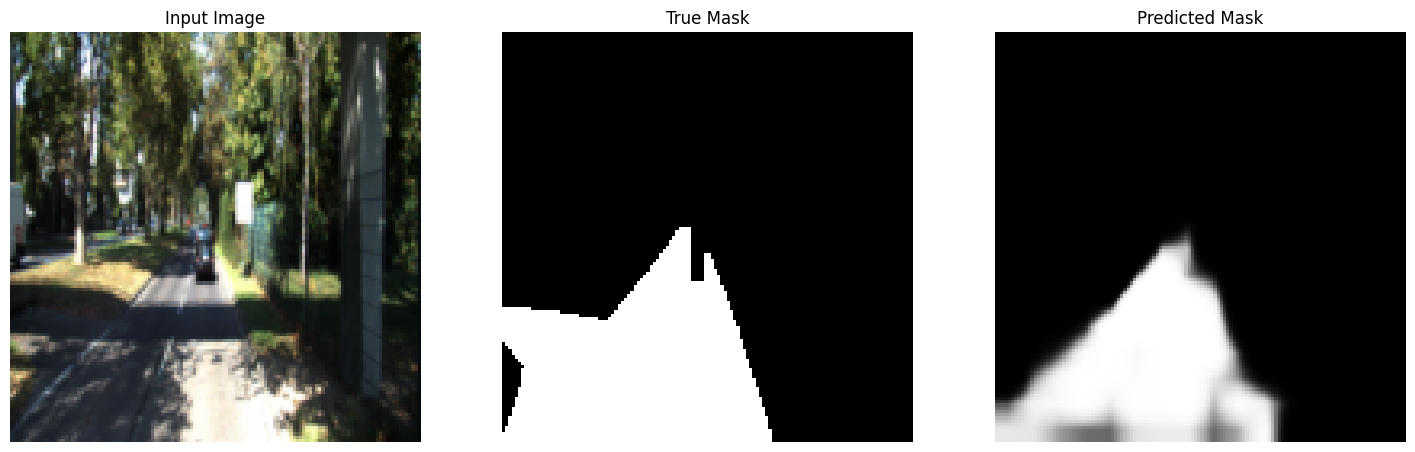

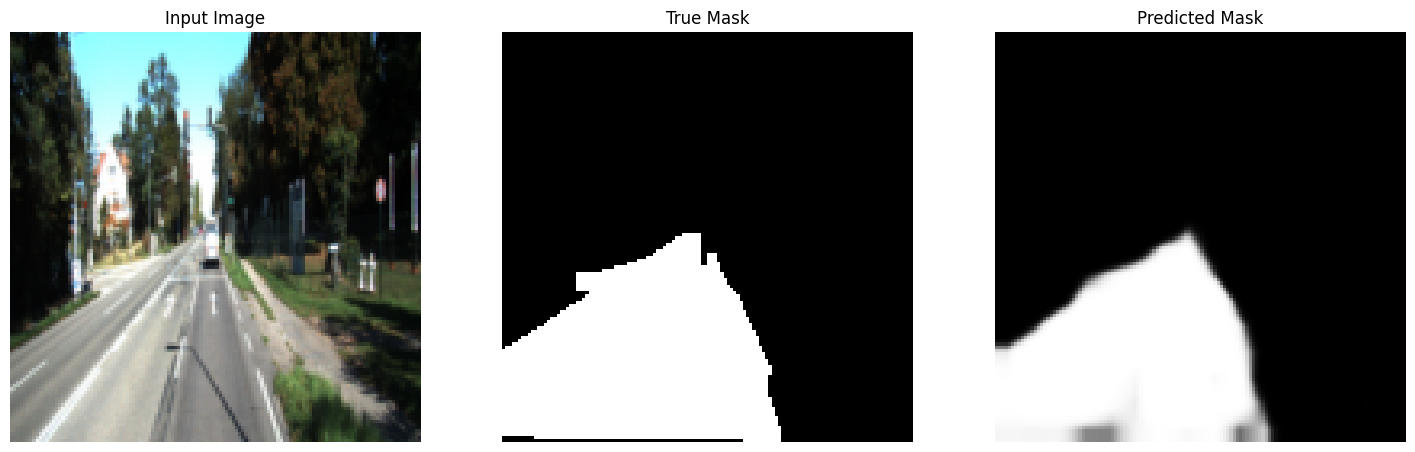

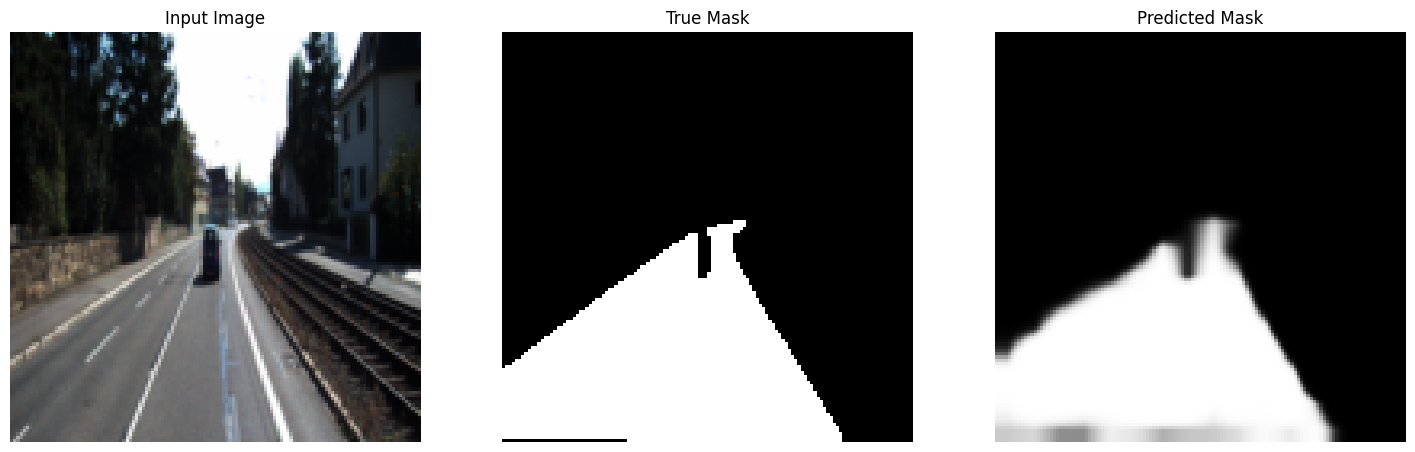

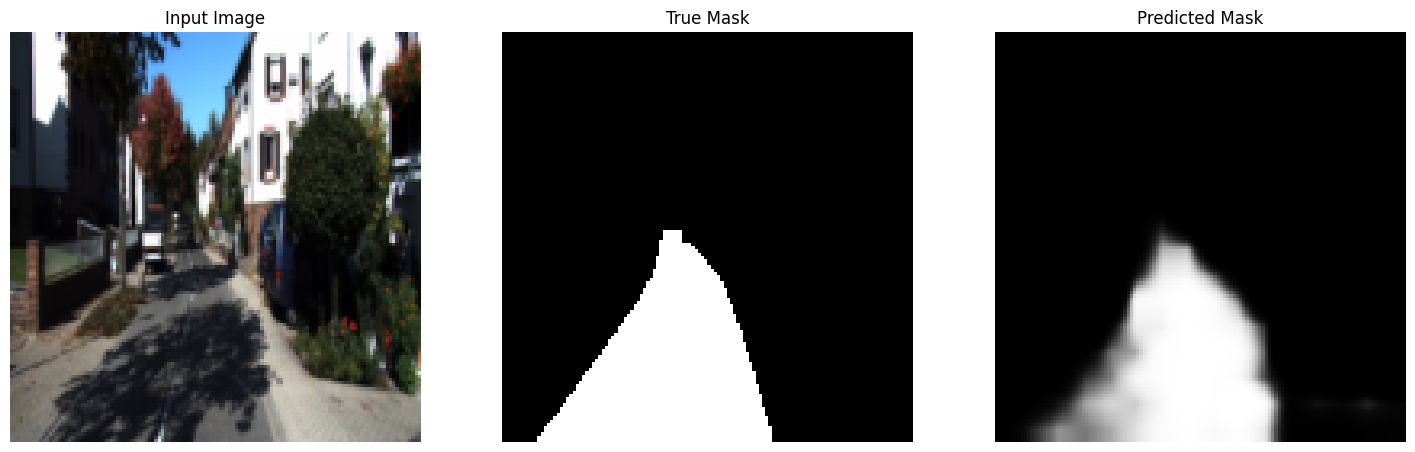

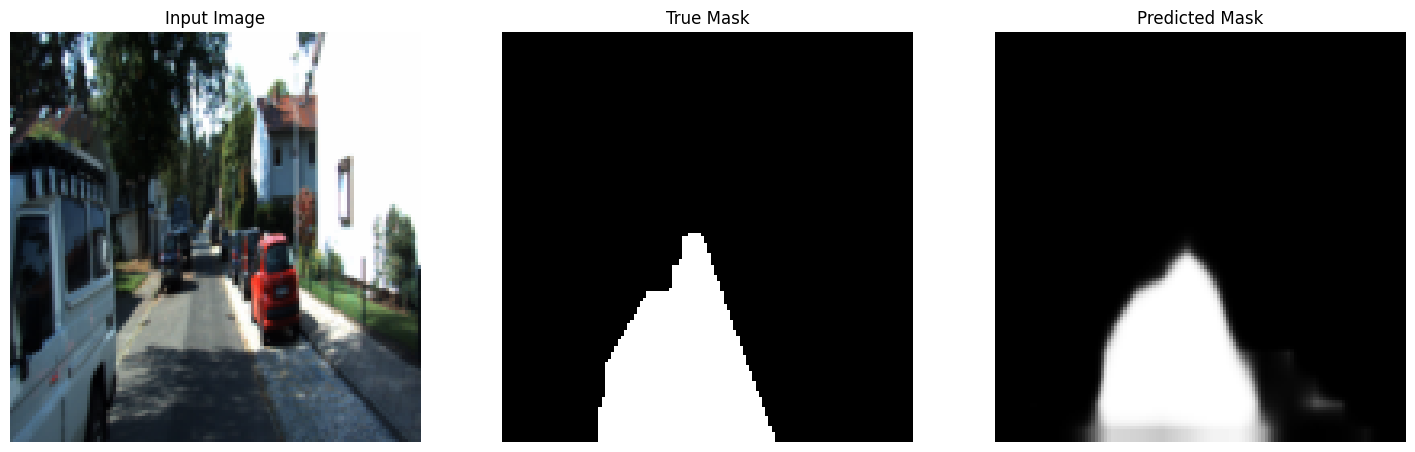

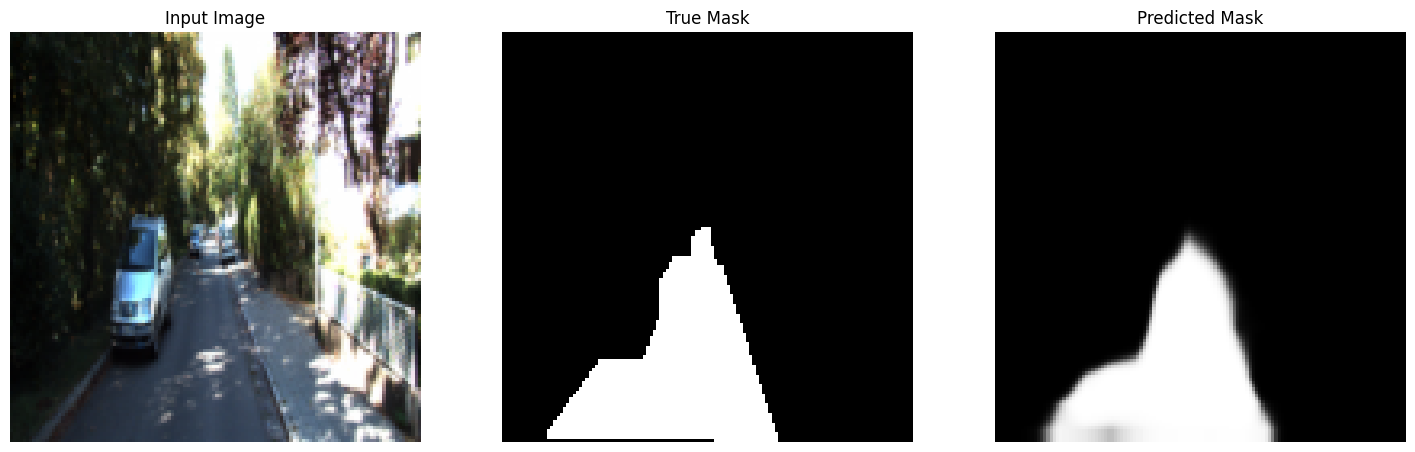

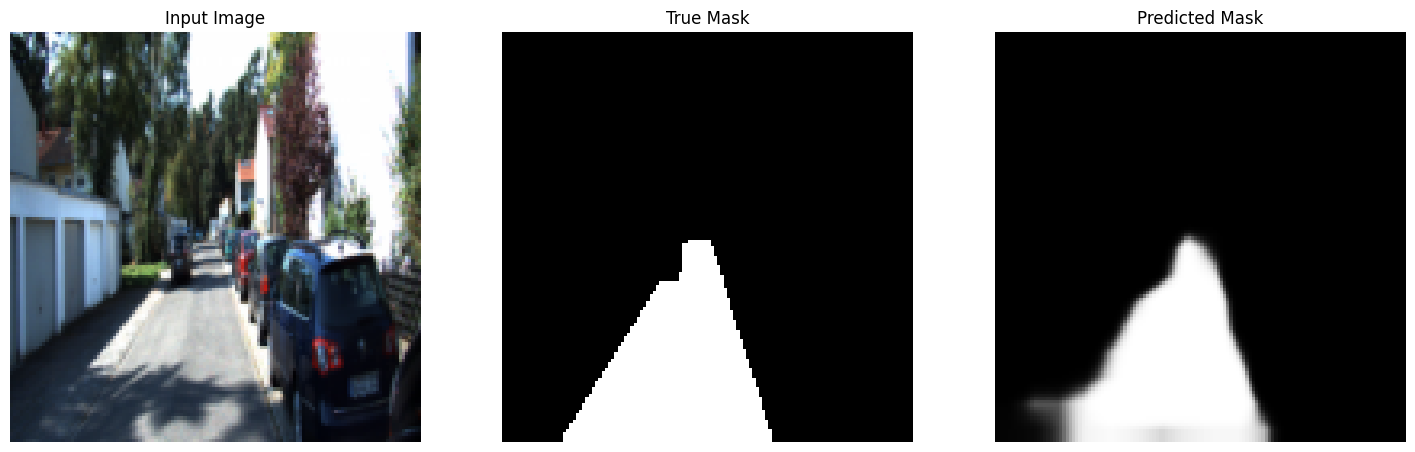

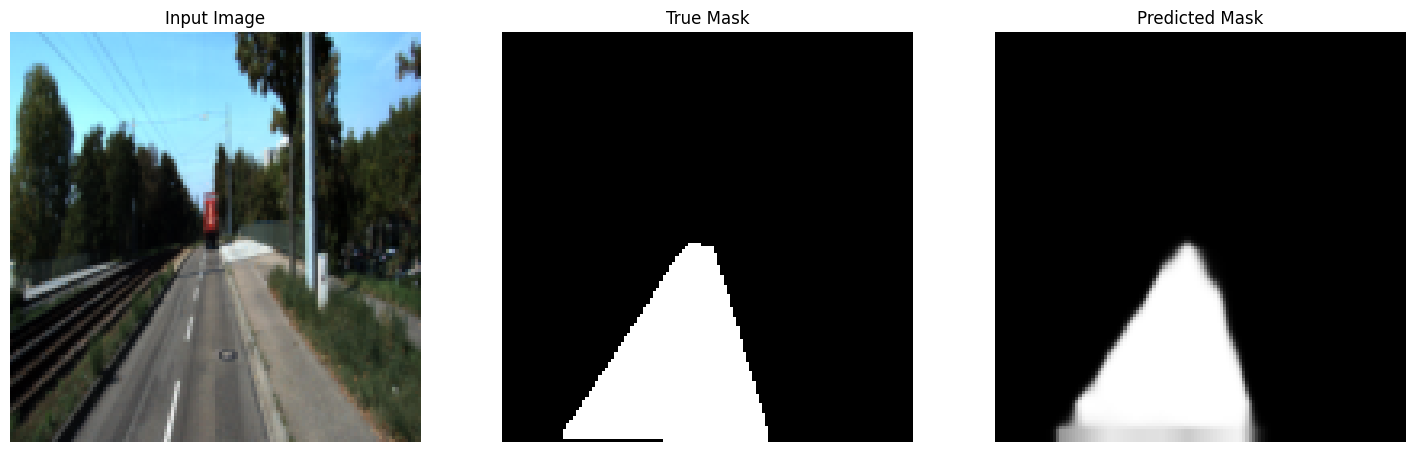

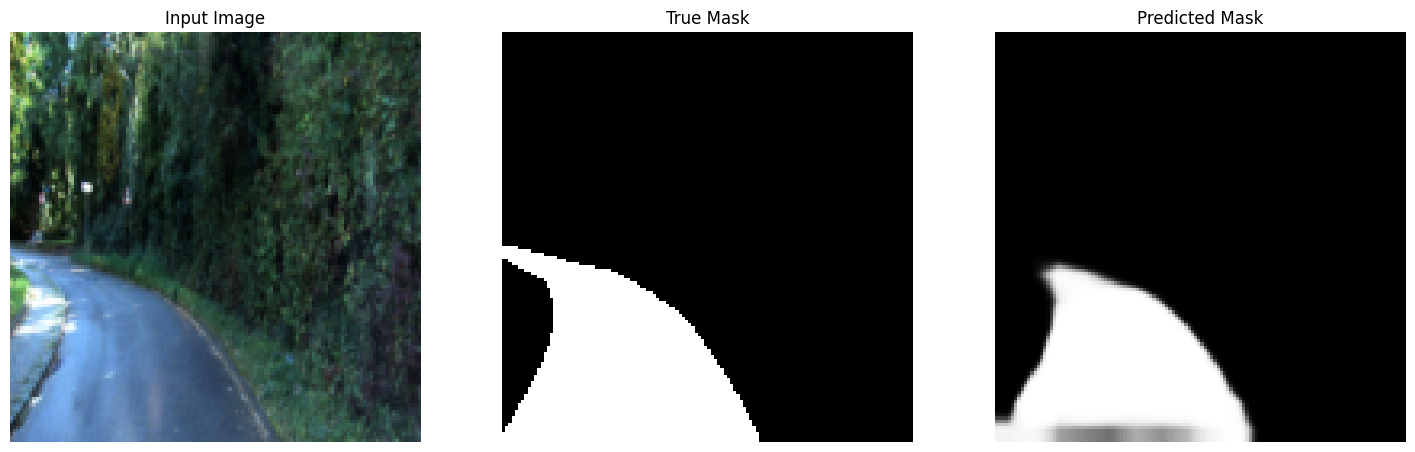

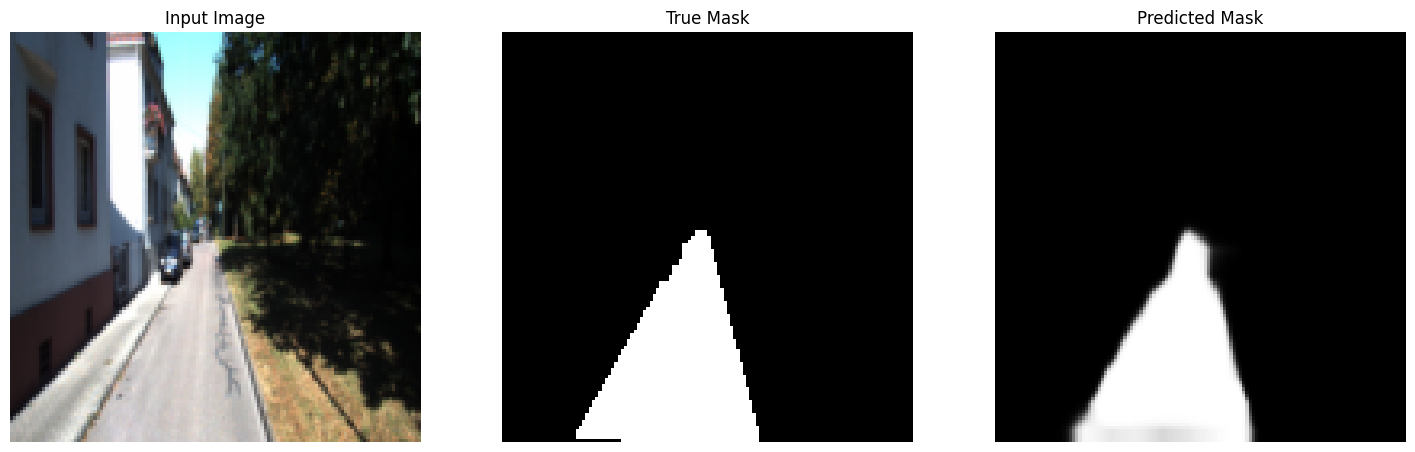

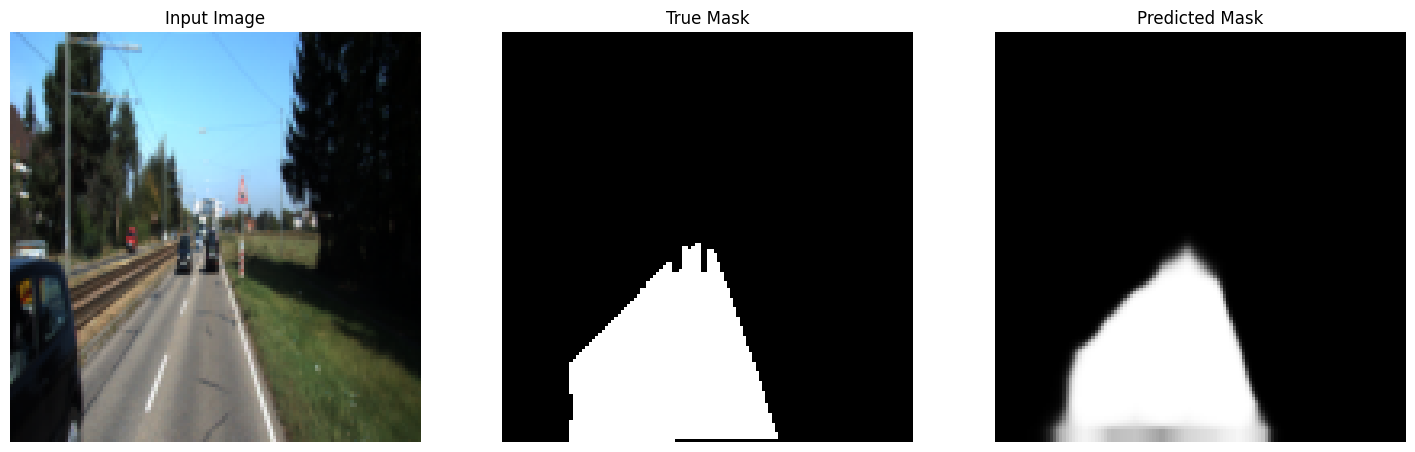

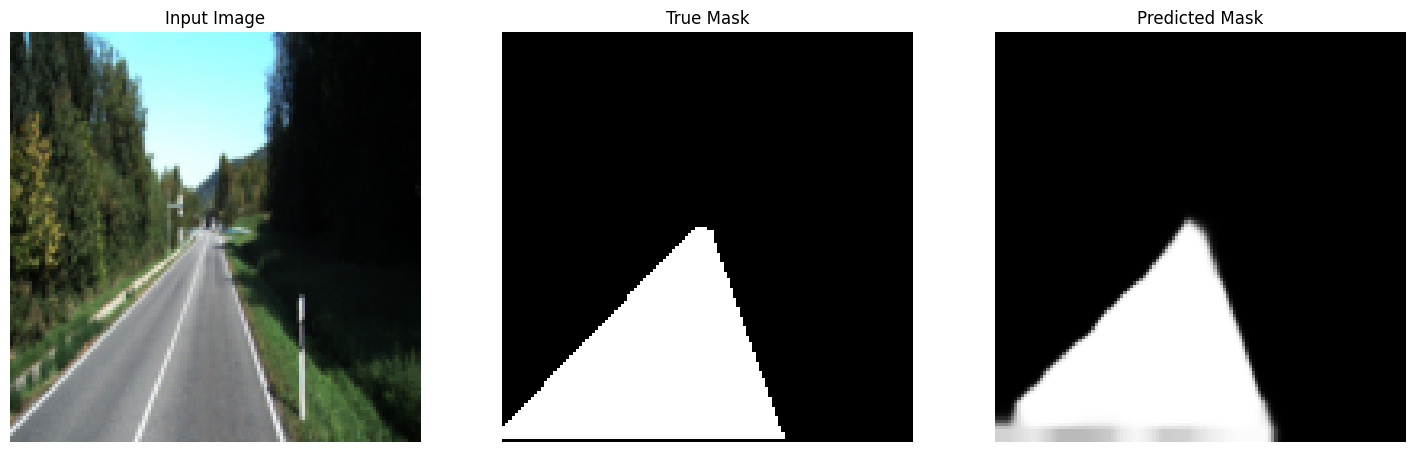

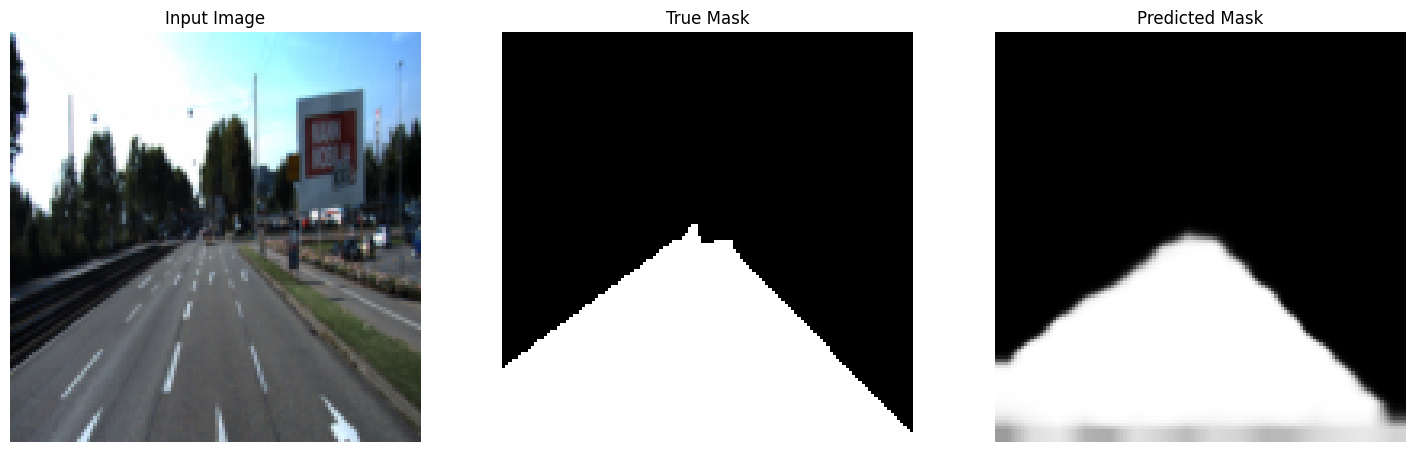

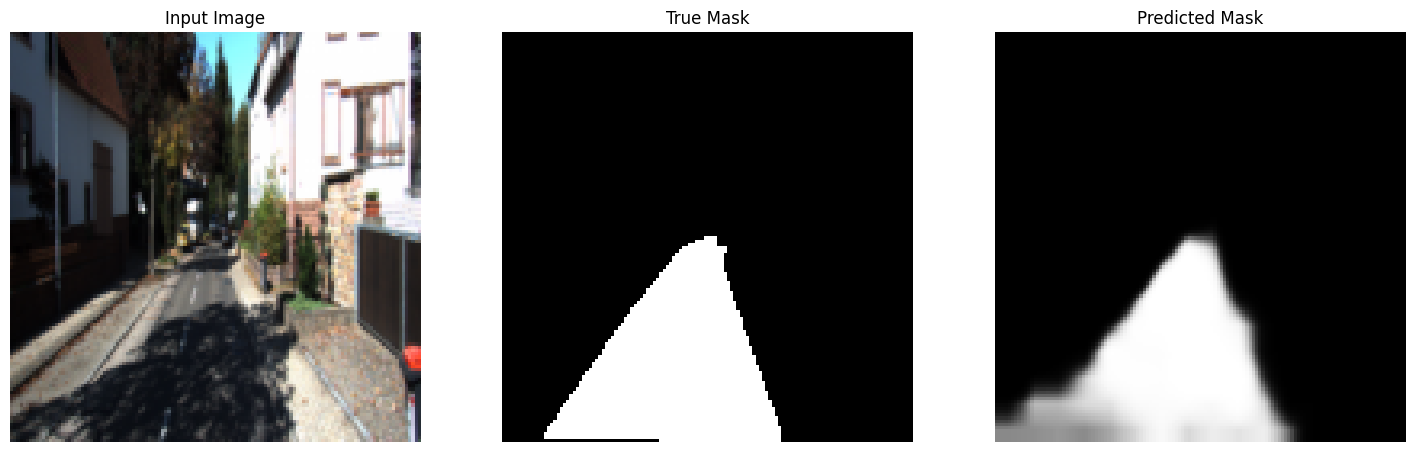

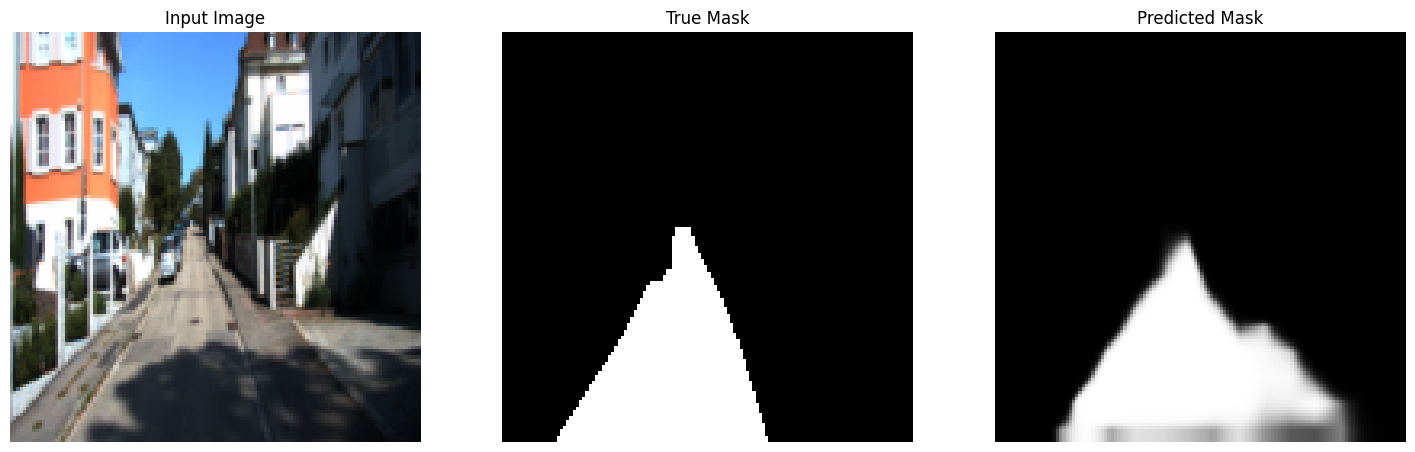

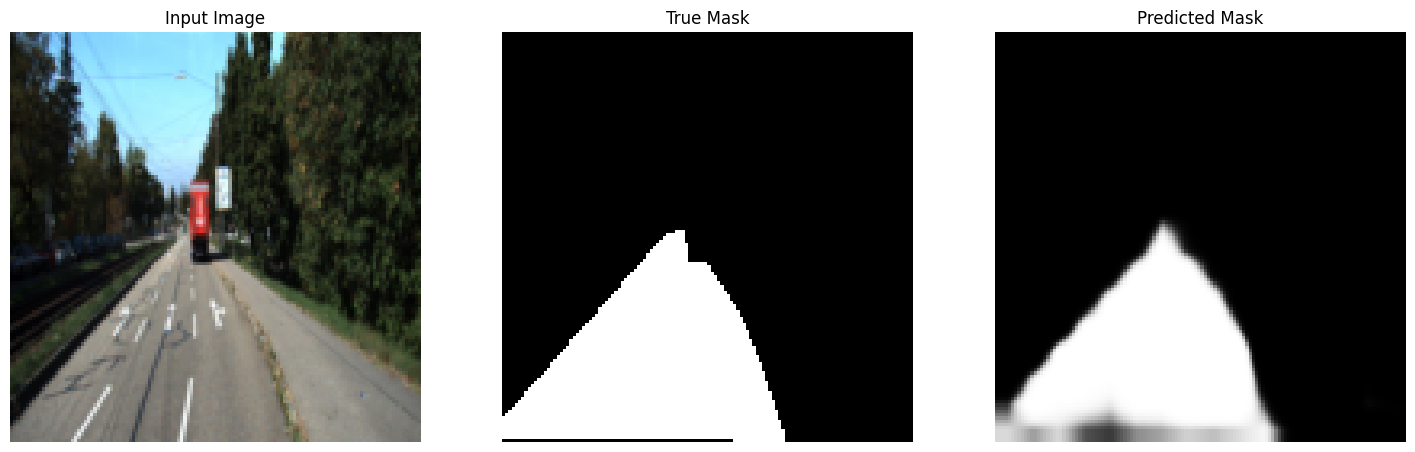

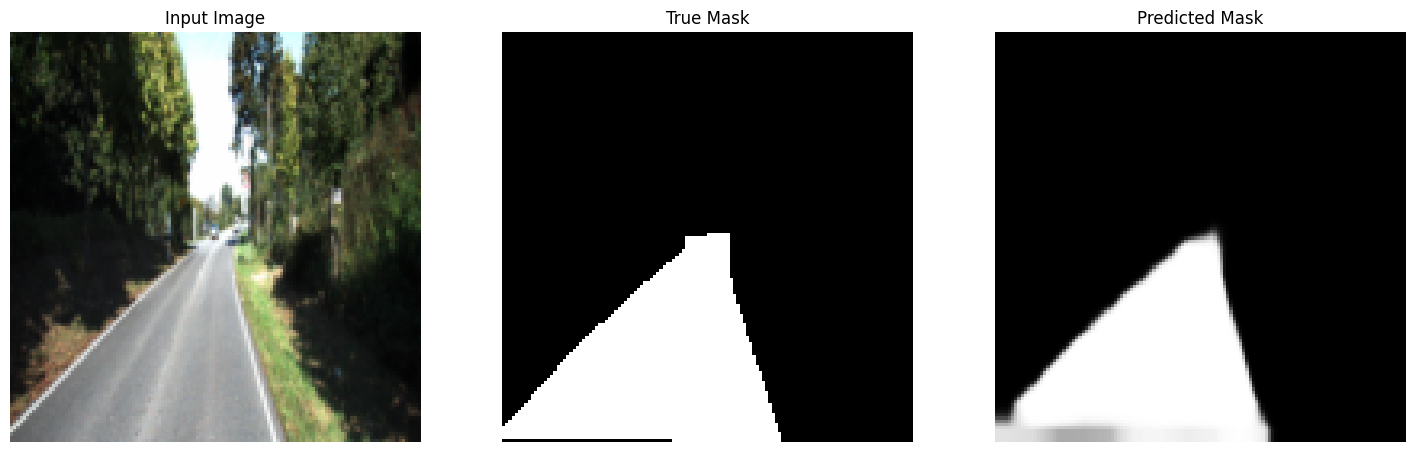

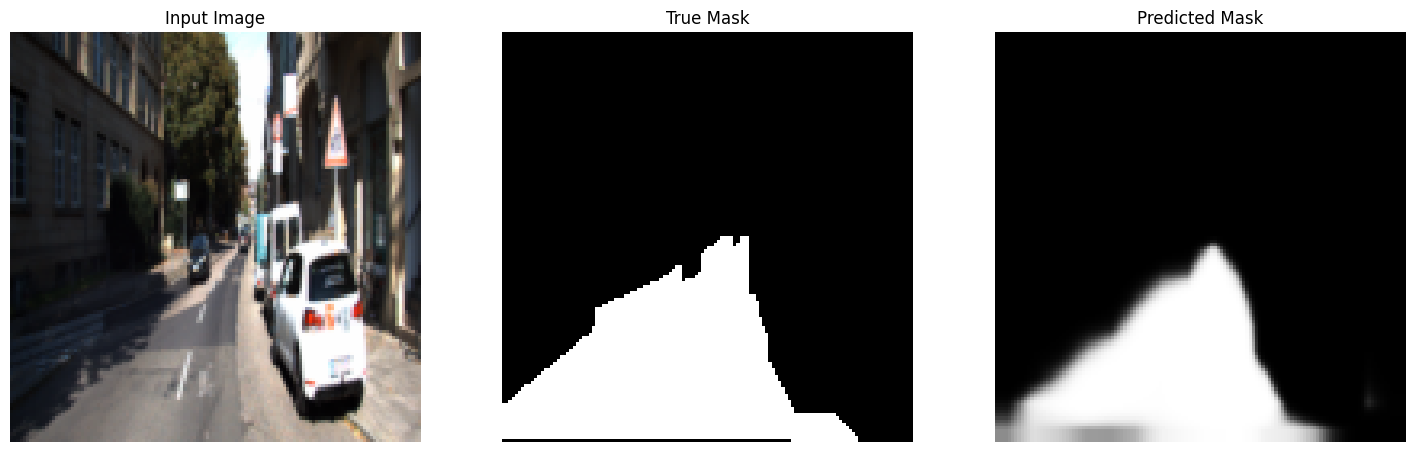

In [ ]:
for i in range(0,20):
  sample_image = test_dataset[i][0]
  sample_mask = test_dataset[i][1]
  model.eval()
  sample_pred = model(sample_image.unsqueeze(0).to(device))
  x = torch.where(sample_pred.squeeze(0).detach().to('cpu') > 0.8, torch.tensor(1.0), torch.tensor(0.0))
  display_sample([sample_image, sample_mask, sample_pred.squeeze(0).detach().to('cpu')])

#Load model and test on video frames

In [17]:
# Install necessary libraries
!pip install opencv-python-headless torch torchvision

# Import libraries
import cv2
import torch
from torchvision import transforms
import numpy as np
import time
from google.colab import files

# Upload the input video from https://github.com/AnirudhSB/AI-Hub/blob/main/Lane_Detection/inputs/lane_video1.mp4

input_video_path = 'lane_video1.mp4' #list(uploaded.keys())[0]
output_video_path = 'lane_video1_output.mp4'

# Custom transform function
custom_transform = transforms.Compose([
    transforms.ToPILImage(),             # Convert frame to PIL image
    transforms.Resize((IMG_SIZE, IMG_SIZE)),       # Resize to match the input size of the model
    transforms.ToTensor(),               # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load the model from https://github.com/AnirudhSB/AI-Hub/blob/main/Lane_Detection/Ckpt/LaneDetection_VGGNet16_pretrained.pth
model = VGG_FCN8(n_classes=N_CLASSES)
model.load_state_dict(torch.load('LaneDetection_VGGNet16_pretrained.pth', map_location=torch.device('cpu')))
model.eval()

# Open the input video
cap = cv2.VideoCapture(input_video_path)

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Set up the video writer
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Initialize variables for throughput calculation
frame_count = 0
start_time = time.time()

# Process each frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert BGR (OpenCV) to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Apply the custom transform
    transformed_frame = custom_transform(frame_rgb).unsqueeze(0)  # Add batch dimension

    # Measure inference time for each frame
    with torch.no_grad():
        mask = model(transformed_frame)

    # Convert the mask tensor to a numpy array
    mask_np = mask.squeeze().cpu().numpy()  # shape: (128, 128)

    # Normalize the mask to range 0-255 and convert to uint8
    mask_rescaled = cv2.normalize(mask_np, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Resize the mask to match the frame dimensions
    mask_resized = cv2.resize(mask_rescaled, (frame_width, frame_height))

    # Convert the single-channel mask to a 3-channel image
    mask_colored = cv2.applyColorMap(mask_resized, cv2.COLORMAP_JET)

    # Overlay the mask on the frame
    overlay = cv2.addWeighted(frame, 0.7, mask_colored, 0.3, 0)

    # Write the frame to the output video
    out.write(overlay)

    # Increment the frame count
    frame_count += 1

# End time after processing all frames
end_time = time.time()
total_time = end_time - start_time

# Calculate throughput (frames per second)
throughput = frame_count / total_time

print(f"\nTotal frames processed: {frame_count}")
print(f"Total processing time: {total_time:.2f} seconds")
print(f"Model inference throughput: {throughput:.2f} FPS")
# Release resources
cap.release()
out.release()
print(f"Output video saved to: {output_video_path}")

# Download the output video
files.download(output_video_path)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-17-48c037319a87>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). I


Total frames processed: 1799
Total processing time: 495.81 seconds
Model inference throughput: 3.63 FPS
Output video saved to: lane_video1_output.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>